## Dataset Source  
- The dataset used in this project is from [Kaggle](https://www.kaggle.com/datasets/delfinaoliva/movies).

In [3]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('movies_data.csv', encoding='ISO-8859-1')
df.head(3)


,Movie,Director,Running time,Actor 1,Actor 2,Actor 3,Genre,Budget,Box Office,Actors Box Office %,Director Box Office %,Earnings,Oscar and Golden Globes nominations,Oscar and Golden Globes awards,Release year,IMDb score
0,13 Hours,Michael Bay,144,Toby Stephens,James Badge Dale,David Costabile,Action,50000000,69400000,50.00,69.23,19400000,0,0.0,2016,7.4
1,16 Blocks,Richard Donner,102,Bruce Willis,David Zayas,Sasha Roiz,Action,52000000,65000000,33.33,50.00,13000000,0,0.0,2006,6.6
2,17 Again,Burr Steers,102,Matthew Perry,Hunter Parrish,Thomas Lennon,Comedy,20000000,139000000,44.44,25.00,119000000,0,0.0,2009,6.4


In [ ]:
'''
Calculating Star Power
1. Count how many times each actor appears in the dataset.
2. Assign weighted star power to each actor based on their position (Actor 1 > Actor 2 > Actor 3).
'''

# Count times of  actors appearing 
all_actors = df[['Actor 1', 'Actor 2', 'Actor 3']].values.flatten()
actor_counts = Counter(all_actors)

# Calculate Star Power（Actor1 > Actor2 > Actor3）
df['star_power'] = df.apply(lambda row: 
    1.5 * actor_counts[row['Actor 1']] + 
    1.2 * actor_counts[row['Actor 2']] + 
    1.0 * actor_counts[row['Actor 3']], axis=1)

df['star_power'] = df['star_power'].fillna(0)
print("Now star_power` calculated successfully.")


Now star_power` calculated successfully.


In [5]:
'''
Calculating Director Power
1. Count how many times each director appears in the dataset.
'''

director_counts = Counter(df['Director'])
df['director_power'] = df['Director'].map(director_counts).fillna(0)
print("Now director_power` calculated successfully.")


Now director_power` calculated successfully.


In [6]:
'''
Calculating Success Rating
- Success Rating = Box Office / Budget
- Define classification target "is_hit" based on a threshold.
'''

df['success_rating'] = df['Box Office'] / df['Budget']
df['is_hit'] = (df['success_rating'] >= 3).astype(int)
print("Now is_hit` column created successfully.")


Now is_hit` column created successfully.


In [7]:
'''
Calculating Actor & Director Success Rate
'''

# Calculate actor success rate (personal reputation)
actor_success_counts = {}
actor_total_counts = {}

for _, row in df.iterrows():
    actors = [row['Actor 1'], row['Actor 2'], row['Actor 3']]
    is_hit = row['is_hit']
    
    for actor in actors:
        if actor not in actor_total_counts:
            actor_total_counts[actor] = 0
            actor_success_counts[actor] = 0
        actor_total_counts[actor] += 1
        if is_hit == 1:
            actor_success_counts[actor] += 1

actor_success_rate = {actor: (actor_success_counts[actor] / actor_total_counts[actor])
                      for actor in actor_total_counts}

df['actor_success_rate'] = df.apply(lambda row: 
                                    (actor_success_rate.get(row['Actor 1'], 0) +
                                     actor_success_rate.get(row['Actor 2'], 0) +
                                     actor_success_rate.get(row['Actor 3'], 0)) / 3, axis=1)

# Calculate director success rate (personal reputation)
director_success_counts = df.groupby('Director')['is_hit'].sum()
director_total_counts = df.groupby('Director')['is_hit'].count()
director_success_rate = (director_success_counts / director_total_counts).fillna(0).to_dict()

df['director_success_rate'] = df['Director'].map(director_success_rate)

print("Now actor_success_rate` and `director_success_rate` calculated successfully!")


Now actor_success_rate` and `director_success_rate` calculated successfully!


In [8]:
'''
Recalculating Title Length
'''
df['title_length'] = df['Movie'].apply(len)
print("Now title_length` recalculated successfully.")


Now title_length` recalculated successfully.


In [9]:
'''
One-hot Encoding for Genre - Ensuring it's already processed
'''

genre_columns = [col for col in df.columns if col.startswith('Genre_')]

if genre_columns:
    print(f"Genre One-hot Encoding already exists with {len(genre_columns)} categories.")
else:
    # Make sure genre exists
    if 'Genre' in df.columns:

        df['Genre'] = df['Genre'].fillna("Unknown").replace("", "Unknown")

        df = df.assign(Genre=df['Genre'].str.split(', ')).explode('Genre')

        # One-hot Encoding
        df = pd.get_dummies(df, columns=['Genre'])

        # Make sure every movie belongs to at least one genre
        genre_columns = [col for col in df.columns if col.startswith('Genre_')]
        df['genre_sum'] = df[genre_columns].sum(axis=1)

        if (df['genre_sum'] == 0).sum() > 0:
            print("Some movies have no assigned genre. Assigning `Genre_Unknown` as True.")
            if 'Genre_Unknown' not in df.columns:
                df['Genre_Unknown'] = 0
            df.loc[df['genre_sum'] == 0, 'Genre_Unknown'] = 1

        df.drop(columns=['genre_sum'], inplace=True)

        print("Genre One-hot Encoding completed.")
    else:
        raise KeyError("Column 'Genre' not found in DataFrame! Check if One-hot Encoding has already been applied.")


Genre One-hot Encoding completed.


In [10]:
'''
Calculating Budget per Star Power
'''

df['budget_per_star_power'] = df['Budget'] / (df['star_power'] + 1)
print("Now budget_per_star_power` calculated successfully.")


Now budget_per_star_power` calculated successfully.


In [11]:
'''
Processing Release Year (Normalization)
'''

df['release_year_norm'] = (df['Release year'] - df['Release year'].min()) / (df['Release year'].max() - df['Release year'].min())
print("Now release_year_norm` calculated successfully.")


Now release_year_norm` calculated successfully.


In [ ]:
'''
Splitting Data into Train, Validation, and Test Sets
'''

feature_columns = ['star_power', 'director_power', 'budget_per_star_power', 'title_length', 
                   'Running time', 'Budget', 'release_year_norm', 'actor_success_rate', 'director_success_rate']
# Add all specific genres as columns
feature_columns += [col for col in df.columns if col.startswith('Genre_')]
target_column = 'is_hit'

X = df[feature_columns]
y = df[target_column]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Normalization
scaler = MinMaxScaler()
X_train[feature_columns] = scaler.fit_transform(X_train[feature_columns])
X_val[feature_columns] = scaler.transform(X_val[feature_columns])
X_test[feature_columns] = scaler.transform(X_test[feature_columns])

print(f"Data split completed! Train Size: {X_train.shape}, Validation Size: {X_val.shape}, Test Size: {X_test.shape}")


Data split completed! Train Size: (3179, 23), Validation Size: (397, 23), Test Size: (398, 23)


In [ ]:
'''
Hyperparameter Tuning with RandomizedSearchCV for RandomForest
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the hyperparameter search space
param_dist = {
    'n_estimators': randint(500, 2000),  # Randomly select between 500 and 2000
    'max_depth': [20, 30, None],  # Limit the maximum depth of trees
    'min_samples_split': randint(2, 10),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 4),  # Minimum number of samples required at a leaf node
    'max_features': ['sqrt'],  # Fixed max_features as 'sqrt'
    'class_weight': [{0: 1, 1: 6}],
    'random_state': [42]
}

# Run RandomizedSearchCV for hyperparameter tuning
rf = RandomForestClassifier(n_jobs=-1)
random_search = RandomizedSearchCV(
    rf, param_dist,
    n_iter=15,  # Search 15 sets of hyperparameters (faster than GridSearchCV)
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the final model using the best hyperparameters
best_rf_model = random_search.best_estimator_

# Evaluate the best model
y_val_pred = best_rf_model.predict(X_val)

print(f"Optimized RandomForest Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))


Best Hyperparameters: {'class_weight': {0: 1, 1: 6}, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1356, 'random_state': 42}
Optimized RandomForest Validation Accuracy: 0.9395
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       251
           1       0.88      0.97      0.92       146

    accuracy                           0.94       397
   macro avg       0.93      0.95      0.94       397
weighted avg       0.94      0.94      0.94       397

[[232  19]
 [  5 141]]


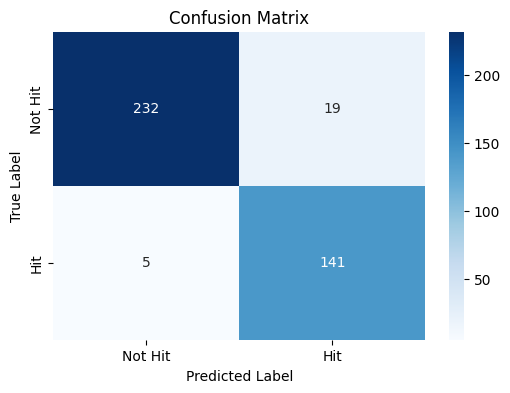

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Show confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hit", "Hit"], yticklabels=["Not Hit", "Hit"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


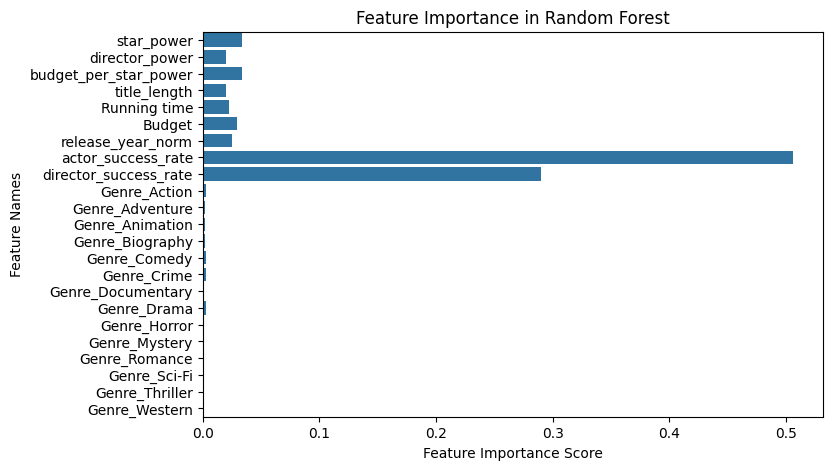

In [ ]:
# The most important features
feature_importances = best_rf_model.feature_importances_
feature_names = X_train.columns

# Show feature importance in graph
plt.figure(figsize=(8,5))
sns.barplot(x=feature_importances, y=feature_names)
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Names")
plt.title("Feature Importance in Random Forest")
plt.show()


## Conclusion
- The best model achieved **93.95% accuracy**.
- The model is very strong in predicting **non-hit movies** (98% precision) and **hit movies** (97% recall).
- The most important features in predicting movie success are **star power, director power, and actor success rate**.